In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from prophet import Prophet

In [3]:
# Load the data
x_train = pd.read_csv('../data-challenge/x_train_sncf.csv')
x_test = pd.read_csv('../data-challenge/x_test_sncf.csv')
y_train = pd.read_csv('../data-challenge/y_train_sncf.csv')

In [4]:
# add the index column on x_train
x_train['index'] = x_train['date'].str.cat(x_train['station'], sep='_')
x_train.head()

,date,station,job,ferie,vacances,index
0,2015-01-01,1J7,1,1,1,2015-01-01_1J7
1,2015-01-01,O2O,1,1,1,2015-01-01_O2O
2,2015-01-01,8QR,1,1,1,2015-01-01_8QR
3,2015-01-01,UMC,1,1,1,2015-01-01_UMC
4,2015-01-01,FK3,1,1,1,2015-01-01_FK3


In [5]:
# merge x_train and y_train on index
data_train = pd.merge(x_train, y_train, on='index')
data_train = data_train[['date', 'station', 'index', 'job', 'ferie', 'vacances', 'y']]
data_train['train'] = 1

data_train.head()

,date,station,index,job,ferie,vacances,y,train
0,2015-01-01,1J7,2015-01-01_1J7,1,1,1,7,1
1,2015-01-01,O2O,2015-01-01_O2O,1,1,1,0,1
2,2015-01-01,8QR,2015-01-01_8QR,1,1,1,9,1
3,2015-01-01,UMC,2015-01-01_UMC,1,1,1,9,1
4,2015-01-01,FK3,2015-01-01_FK3,1,1,1,28,1


In [6]:
# merge the above data with x_test
x_test['train'] = 0
merged_data = pd.concat([data_train, x_test], ignore_index=True).sort_values(by=['date'])
merged_data['y'] = merged_data['y'].fillna(0)

merged_data.tail()

,date,station,index,job,ferie,vacances,y,train
1307138,2023-06-30,4AH,2023-06-30_4AH,1,0,0,0.0,0
1307139,2023-06-30,8XN,2023-06-30_8XN,1,0,0,0.0,0
1307140,2023-06-30,ESA,2023-06-30_ESA,1,0,0,0.0,0
1307129,2023-06-30,X6B,2023-06-30_X6B,1,0,0,0.0,0
1306842,2023-06-30,HW6,2023-06-30_HW6,1,0,0,0.0,0


In [7]:
stations = merged_data['station'].unique()
stations

array(['1J7', 'S3E', 'RDK', 'I9U', 'OM7', '09U', '0S9', 'KO0', '4WI',
       '23N', 'WVV', 'SWS', 'TFW', 'X3T', 'I8D', 'EOE', 'MBC', 'VS0',
       'EVR', 'BZL', 'DF2', 'APM', '12Q', 'L6F', 'WDP', 'ZII', 'W67',
       '4V8', '214', '2YA', 'L15', 'PRZ', '2UV', 'OF0', 'PCE', 'UAJ',
       'K75', '9RF', '2EW', '6E0', '033', 'KHT', 'P8U', 'CW1', 'AK3',
       'IJR', 'CM6', 'NZP', 'ICH', 'Q62', '19G', 'CS1', 'T2H', 'TMT',
       'DRI', 'KAX', 'BC6', '6VM', 'UCE', '0CM', 'V5L', 'BI7', 'Q5M',
       '1EB', 'IAM', 'AOW', 'YX9', '7EJ', '0WC', 'WQR', 'WQO', 'LHY',
       '193', 'PQF', 'XN6', '0YY', '1VL', '1AA', 'A1R', '9P6', '6HE',
       '700', 'SZ5', 'H2M', 'SSM', 'G1F', 'QTM', 'K6N', 'N6O', 'HZ1',
       'ZIK', '294', 'Y1C', 'BUH', 'XM1', '0GU', 'B34', 'NXN', '9MC',
       'JFA', 'AGN', 'I6E', 'W68', 'VZD', 'V6N', '5SM', 'UM6', '4RW',
       'MPO', 'MX8', 'MBB', 'FTX', 'PD6', 'T16', 'I10', 'WNT', '4EG',
       'X2X', 'HN1', 'ARC', 'T5V', 'K2M', 'V2R', 'OE1', '94K', 'C5E',
       'VTE', '2T1',

In [8]:
df_per_station = {station: merged_data[merged_data['station'] == station].sort_values(by='date')[["date", "job", "ferie", "vacances", "y", "train"]] for station in stations}

In [9]:
df_per_station['O2O'].head()

,date,job,ferie,vacances,y,train
1,2015-01-01,1,1,1,0.0,1
40303,2015-01-02,1,0,1,8.0,1
80892,2015-01-03,0,0,1,0.0,1
121380,2015-01-04,0,0,1,0.0,1
161890,2015-01-05,1,0,0,27.0,1


In [10]:
print(list(df_per_station['O2O']['y']))

[0.0, 8.0, 0.0, 0.0, 27.0, 35.0, 21.0, 31.0, 27.0, 0.0, 0.0, 24.0, 22.0, 20.0, 24.0, 24.0, 0.0, 5.0, 24.0, 22.0, 27.0, 25.0, 21.0, 6.0, 0.0, 22.0, 22.0, 24.0, 22.0, 23.0, 0.0, 0.0, 27.0, 33.0, 20.0, 25.0, 23.0, 8.0, 31.0, 23.0, 20.0, 21.0, 22.0, 16.0, 0.0, 12.0, 25.0, 25.0, 15.0, 20.0, 19.0, 0.0, 6.0, 14.0, 11.0, 18.0, 16.0, 19.0, 0.0, 7.0, 24.0, 24.0, 20.0, 26.0, 20.0, 6.0, 13.0, 22.0, 19.0, 21.0, 21.0, 22.0, 0.0, 14.0, 25.0, 28.0, 15.0, 19.0, 18.0, 7.0, 5.0, 23.0, 24.0, 19.0, 20.0, 18.0, 0.0, 9.0, 23.0, 27.0, 19.0, 19.0, 17.0, 0.0, 14.0, 19.0, 22.0, 22.0, 18.0, 22.0, 5.0, 0.0, 23.0, 25.0, 22.0, 29.0, 17.0, 0.0, 5.0, 20.0, 21.0, 17.0, 21.0, 16.0, 0.0, 0.0, 22.0, 22.0, 16.0, 18.0, 0.0, 0.0, 15.0, 26.0, 27.0, 24.0, 21.0, 0.0, 6.0, 0.0, 26.0, 19.0, 15.0, 0.0, 6.0, 0.0, 6.0, 20.0, 15.0, 19.0, 23.0, 24.0, 6.0, 0.0, 5.0, 22.0, 19.0, 21.0, 20.0, 0.0, 15.0, 18.0, 20.0, 16.0, 19.0, 14.0, 0.0, 0.0, 20.0, 21.0, 16.0, 22.0, 21.0, 0.0, 37.0, 21.0, 21.0, 5.0, 17.0, 7.0, 12.0, 19.0, 14.0, 12.0, 18.0

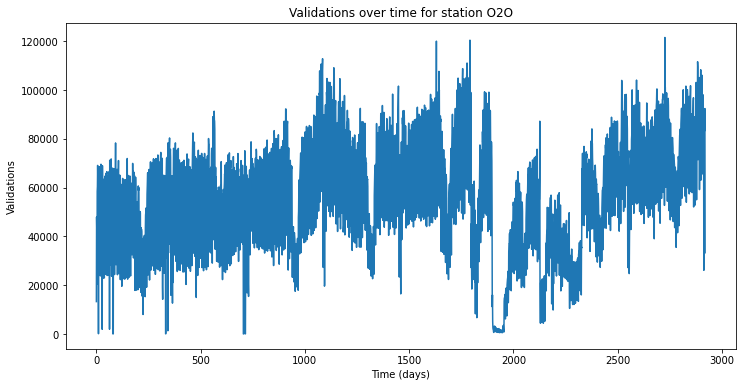

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(np.array(df_per_station['CQT'][df_per_station['CQT']['train'] == 1]['y']))
plt.xlabel('Time (days)')
plt.ylabel('Validations')
plt.title('Validations over time for station O2O')
plt.show()

In [12]:
def mean_absolute_percentage_error(y_true, y_pred, eps=1e-6):
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

In [13]:
# Create an empty y_test dataframe
y_test = pd.DataFrame()
# Convert 'date' column to string type
x_test['date'] = x_test['date'].astype(str)
# First column name is 'index'
y_test['index'] = x_test['date'].str.cat(x_test['station'], sep='_')
# Second column name is 'y'
y_test['y'] = 0

print(y_test.head())

            index  y
0  2023-01-01_1J7  0
1  2023-01-01_O2O  0
2  2023-01-01_8QR  0
3  2023-01-01_L58  0
4  2023-01-01_UMC  0


# Random Forest

In [14]:
# from sklearn.ensemble import RandomForestRegressor

# for i, station in enumerate(stations):
#     print(f"Training for station {station}, step {i+1}")
#     df = df_per_station[station]
#     X_train = df[df['train'] == 1][['date', 'job', 'ferie', 'vacances']]
#     y_train = df[df['train'] == 1]['y']
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#     X_test = df[df['train'] == 0][['date', 'job', 'ferie', 'vacances']]

#     rf = RandomForestRegressor(n_estimators=100, random_state=42)
#     rf.fit(X_train[['job', 'ferie', 'vacances']], y_train)
#     y_pred_val = rf.predict(X_val[['job', 'ferie', 'vacances']])
#     print(f"MAPE for station {station} on validation set: {mean_absolute_percentage_error(y_val, y_pred_val)}")

#     y_pred = rf.predict(X_test[['job', 'ferie', 'vacances']])
#     y_test.loc[y_test['index'].str.contains(station), 'y'] = y_pred

# y_test.to_csv('y_test_submit_rf_each_station.csv')

# Bagging regressor (does not improve)

In [15]:
# from sklearn.ensemble import BaggingRegressor
# from sklearn.svm import SVR
# from sklearn.neighbors import KNeighborsRegressor as KNN

# for i, station in enumerate(stations):
#     print(f"Training for station {station}, step {i+1}")
#     df = df_per_station[station]
#     X_train = df[df['train'] == 1][['date', 'job', 'ferie', 'vacances']]
#     y_train = df[df['train'] == 1]['y']
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#     X_test = df[df['train'] == 0][['date', 'job', 'ferie', 'vacances']]

#     br = BaggingRegressor(KNN(), n_estimators=10, random_state=42)
#     br.fit(X_train[['job', 'ferie', 'vacances']], y_train)
#     y_pred_val = br.predict(X_val[['job', 'ferie', 'vacances']])
#     print(f"MAPE for station {station} on validation set: {mean_absolute_percentage_error(y_val, y_pred_val)}")

#     y_pred = br.predict(X_test[['job', 'ferie', 'vacances']])
#     y_test.loc[y_test['index'].str.contains(station), 'y'] = y_pred

# y_test.to_csv('y_test_submit_bagging_rf_each_station.csv')

In [16]:
# # Adaboost

# from sklearn.ensemble import AdaBoostRegressor

# for i, station in enumerate(stations):
#     print(f"Training for station {station}, step {i+1}")
#     df = df_per_station[station]
#     X_train = df[df['train'] == 1][['date', 'job', 'ferie', 'vacances']]
#     y_train = df[df['train'] == 1]['y']
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#     X_test = df[df['train'] == 0][['date', 'job', 'ferie', 'vacances']]

#     ab = AdaBoostRegressor(n_estimators=100, random_state=42)
#     ab.fit(X_train[['job', 'ferie', 'vacances']], y_train)
#     y_pred_val = ab.predict(X_val[['job', 'ferie', 'vacances']])
#     print(f"MAPE for station {station} on validation set: {mean_absolute_percentage_error(y_val, y_pred_val)}")

#     y_pred = ab.predict(X_test[['job', 'ferie', 'vacances']])
#     y_test.loc[y_test['index'].str.contains(station), 'y'] = y_pred

# y_test.to_csv('y_test_submit_adaboost_each_station.csv')

In [17]:
# # gradient boosting

# from sklearn.ensemble import GradientBoostingRegressor

# for i, station in enumerate(stations):
#     print(f"Training for station {station}, step {i+1}")
#     df = df_per_station[station]
#     X_train = df[df['train'] == 1][['date', 'job', 'ferie', 'vacances']]
#     y_train = df[df['train'] == 1]['y']
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#     X_test = df[df['train'] == 0][['date', 'job', 'ferie', 'vacances']]

#     gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
#     gb.fit(X_train[['job', 'ferie', 'vacances']], y_train)
#     y_pred_val = gb.predict(X_val[['job', 'ferie', 'vacances']])
#     print(f"MAPE for station {station} on validation set: {mean_absolute_percentage_error(y_val, y_pred_val)}")

#     y_pred = gb.predict(X_test[['job', 'ferie', 'vacances']])
#     y_test.loc[y_test['index'].str.contains(station), 'y'] = y_pred

# y_test.to_csv('y_test_submit_gb_each_station.csv')

In [18]:
# # linear regression

# from sklearn.linear_model import LinearRegression

# for i, station in enumerate(stations):
#     print(f"Training for station {station}, step {i+1}")
#     df = df_per_station[station]
#     X_train = df[df['train'] == 1][['date', 'job', 'ferie', 'vacances']]
#     y_train = df[df['train'] == 1]['y']
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#     X_test = df[df['train'] == 0][['date', 'job', 'ferie', 'vacances']]

#     lr = LinearRegression()
#     lr.fit(X_train[['job', 'ferie', 'vacances']], y_train)
#     y_pred_val = lr.predict(X_val[['job', 'ferie', 'vacances']])
#     print(f"MAPE for station {station} on validation set: {mean_absolute_percentage_error(y_val, y_pred_val)}")

#     y_pred = lr.predict(X_test[['job', 'ferie', 'vacances']])
#     y_test.loc[y_test['index'].str.contains(station), 'y'] = y_pred

# y_test.to_csv('y_test_submit_lr_each_station.csv')

In [19]:
# # XGBoost

# import xgboost as xgb

# for i, station in enumerate(stations):
#     print(f"Training for station {station}, step {i+1}")
#     df = df_per_station[station]
#     X_train = df[df['train'] == 1][['date', 'job', 'ferie', 'vacances']]
#     y_train = df[df['train'] == 1]['y']
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#     X_test = df[df['train'] == 0][['date', 'job', 'ferie', 'vacances']]

#     xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
#                 max_depth = 5, alpha = 10, n_estimators = 100)
#     xg_reg.fit(X_train[['job', 'ferie', 'vacances']], y_train)
#     y_pred_val = xg_reg.predict(X_val[['job', 'ferie', 'vacances']])
#     print(f"MAPE for station {station} on validation set: {mean_absolute_percentage_error(y_val, y_pred_val)}")

#     y_pred = xg_reg.predict(X_test[['job', 'ferie', 'vacances']])
#     y_test.loc[y_test['index'].str.contains(station), 'y'] = y_pred

# y_test.to_csv('y_test_submit_xgb_each_station.csv')

In [20]:
# # LightGBM

# import lightgbm as lgb

# for i, station in enumerate(stations):
#     print(f"Training for station {station}, step {i+1}")
#     df = df_per_station[station]
#     X_train = df[df['train'] == 1][['date', 'job', 'ferie', 'vacances']]
#     y_train = df[df['train'] == 1]['y']
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
#     X_test = df[df['train'] == 0][['date', 'job', 'ferie', 'vacances']]

#     lgb_reg = lgb.LGBMRegressor(objective='regression', num_leaves=64, learning_rate=0.05, n_estimators=100)
#     lgb_reg.fit(X_train[['job', 'ferie', 'vacances']], y_train)
#     y_pred_val = lgb_reg.predict(X_val[['job', 'ferie', 'vacances']])
#     print(f"MAPE for station {station} on validation set: {mean_absolute_percentage_error(y_val, y_pred_val)}")

#     y_pred = lgb_reg.predict(X_test[['job', 'ferie', 'vacances']])
#     y_test.loc[y_test['index'].str.contains(station), 'y'] = y_pred

# y_test.to_csv('y_test_submit_lgb_each_station_2.csv')

In [30]:
# SARIMA

# import datetime
from datetime import datetime

from statsmodels.tsa.statespace.sarimax import SARIMAX

for i, station in enumerate(stations):
    print(f"Training for station {station}, step {i+1}")
    df = df_per_station[station]
    X_train = df[df['train'] == 1][['date', 'job', 'ferie', 'vacances']]
    y_train = df[df['train'] == 1]['y']
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    X_test = df[df['train'] == 0][['date', 'job', 'ferie', 'vacances']]

    sarima = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    sarima = sarima.fit()
    y_pred_val = sarima.predict(start=X_val["date"].iloc[0], end=X_val["date"].iloc[-1])
    print(f"MAPE for station {station} on validation set: {mean_absolute_percentage_error(y_val, y_pred_val)}")

    y_pred = sarima.predict(start=X_test["date"].iloc[0], end=X_test["date"].iloc[-1])
    y_test.loc[y_test['index'].str.contains(station), 'y'] = y_pred

y_test.to_csv('y_test_submit_sarima_each_station.csv')

Training for station 1J7, step 1


/home/talexandre/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/talexandre/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98845D+00    |proj g|=  6.66596D-02


 This problem is unconstrained.



At iterate    5    f=  5.91969D+00    |proj g|=  2.14708D-02

At iterate   10    f=  5.77169D+00    |proj g|=  7.05955D-02

At iterate   15    f=  5.76204D+00    |proj g|=  1.73496D-04
